<a href="https://colab.research.google.com/github/afraa-n/XAI-Adversarial-Patches/blob/main/Adversarial_Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generating Adversarial Patches

Developed by Afraa Noureen with assistance from Claude AI

### Loading Required Libraries and Preparing the Model

1. Load essential libraries and prepare the pre-trained ResNet34 model by setting it to evaluation mode for inference.

2. Retrieve the list of ImageNet class labels from Duke-AI-XAI repository and identify the index for the target class, "ice cream." Use this index to evaluate the effectiveness of the adversarial patch.

3. Define image preprocessing transformations to resize and format input images appropriately for the ResNet34 model.

In [1]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# Load the pre-trained ResNet34 model
model = models.resnet34(weights='IMAGENET1K_V1')
model.eval()

# Load ImageNet classes from provided URL
labels_url = "https://raw.githubusercontent.com/AIPI-590-XAI/Duke-AI-XAI/main/adversarial-ai-example-notebooks/imagenet_classes.txt"
labels = requests.get(labels_url).text.splitlines()

# The index for 'ice cream' in the ImageNet dataset
target_class = labels.index("ice cream")

# Define transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Check if GPU is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = model.to(device)


Using device: cpu


---
### Image Handling Helper Functions

1. Create a function to load and preprocess images from a URL. It retrieves the image, converts it to RGB, and applies necessary transformations. The image is returned as a tensor with an extra batch dimension.

2. Create another function to display an image. It converts the tensor to a NumPy array, rearranges it for display, and shows it using Matplotlib.

In [2]:
# Helper function to load and preprocess images
def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return preprocess(img).unsqueeze(0)

# Helper function to show an image
def show_image(tensor, title=None):
    img = tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

---
### Creating an Ice Cream Patch

This function creates an adversarial patch designed to look like an ice cream scoop. It starts by making a blank patch and setting its color to a light cream shade. It then uses a circular mask to shape the scoop and applies this color within the mask. To add texture, a swirl pattern is created and added to the patch. The final step ensures the pixel values are between 0 and 1 before returning the patch.

In [3]:
def create_ice_cream_patch(patch_size):
    patch = torch.zeros((3, *patch_size), device=device)

    # Create a base color for the ice cream scoop
    base_color = torch.tensor([1.0, 0.8, 0.6], device=device)  # Light cream color

    # Generate grid using NumPy
    y, x = np.ogrid[:patch_size[1], :patch_size[0]]
    center = (patch_size[1] // 2, patch_size[0] // 2)
    radius = patch_size[1] // 3
    mask = (y - center[0])**2 + (x - center[1])**2 <= radius**2

    # Convert mask to torch tensor
    mask = torch.tensor(mask, dtype=torch.bool, device=device)

    # Apply mask to patch
    for i in range(3):
        patch[i][mask] = base_color[i]

    # Add a swirl texture to mimic ice cream texture
    swirl_pattern = torch.sin(torch.linspace(0, 2 * np.pi, patch_size[0])) * 0.1 + 0.5
    swirl_pattern = swirl_pattern.reshape(1, -1).expand(patch_size[1], -1)
    for i in range(3):
        patch[i] += swirl_pattern.to(device) * 0.2

    # Ensure values are between 0 and 1
    patch = torch.clamp(patch, 0, 1)

    return patch


---
### Generating the Adversarial Patch

This function creates an adversarial patch that causes the model to misclassify images as the target class. It starts by generating an initial ice cream-like patch and sets it up for optimization. Using an Adam optimizer, the function iterates through a set number of iterations to adjust the patch.

For each iteration, the patch is applied to different locations on the input images. The model then predicts the class of these patched images. The loss is calculated based on how the target class score compares to the highest score of other classes. The patch is updated based on this loss to make it more effective.

Gradients are managed to prevent instability, and the loss is printed every 50 iterations to monitor progress. The function returns the optimized adversarial patch.

In [4]:
def generate_patch(model, input_images, target_class, iterations=600, lr=0.01):
    global adversarial_patch
    adversarial_patch = create_ice_cream_patch(patch_size)
    adversarial_patch.requires_grad_(True)

    optimizer = torch.optim.Adam([adversarial_patch], lr=lr)

    for i in range(iterations):
        total_loss = 0
        for input_image in input_images:
            input_image = input_image.to(device)

            # Apply the patch to a single random location
            y_offset = torch.randint(0, input_image.size(2) - patch_size[0], (1,)).item()
            x_offset = torch.randint(0, input_image.size(3) - patch_size[1], (1,)).item()
            patched_image = input_image.clone()
            patched_image[:, :, y_offset:y_offset+patch_size[0], x_offset:x_offset+patch_size[1]] = adversarial_patch

            # Forward pass through the model
            output = model(patched_image)

            # Compute loss
            target_score = output[0, target_class]
            other_scores = torch.cat([output[0, :target_class], output[0, target_class+1:]])
            loss = other_scores.max() - target_score
            total_loss += loss

        # Compute gradients and update the adversarial patch
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Clip gradients to avoid instability
        torch.nn.utils.clip_grad_norm_([adversarial_patch], max_norm=1.0)

        # Print loss occasionally
        if i % 50 == 0:
            print(f"Iteration {i}, Loss: {total_loss.item()}")

    return adversarial_patch

---
### Defining Patch Size and Testing

Patch size is set to 64x64 pixels. Test images are loaded from given URLs and prepared for use.

An adversarial patch is created and applied to each test image at random positions. The patched images are displayed to show the effect. The model’s predictions for these patched images are printed, including the top 5 predicted classes and their confidence scores.

Iteration 0, Loss: 42.76002883911133
Iteration 50, Loss: 1.2208290100097656
Iteration 100, Loss: -9.956671714782715
Iteration 150, Loss: -13.099764823913574
Iteration 200, Loss: -16.228435516357422
Iteration 250, Loss: -18.072181701660156
Iteration 300, Loss: -20.1560001373291
Iteration 350, Loss: -20.878801345825195
Iteration 400, Loss: -26.31354522705078
Iteration 450, Loss: -23.2386474609375
Iteration 500, Loss: -23.21782875061035
Iteration 550, Loss: -28.645654678344727


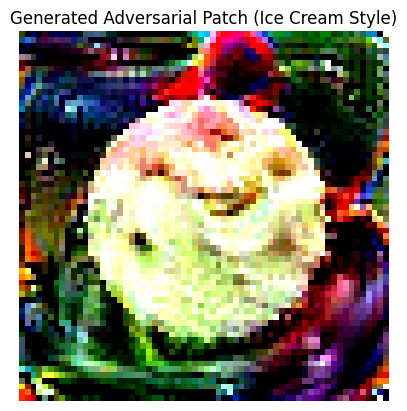

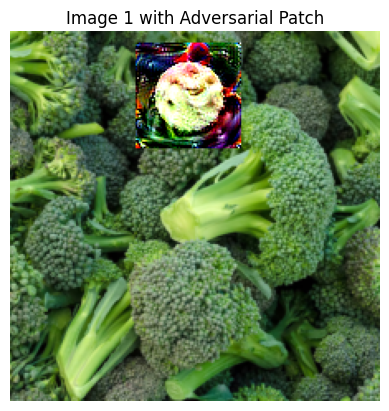

Predictions for Image 1:
Predicted: ice cream, Confidence: 0.9992
Predicted: chocolate sauce, Confidence: 0.0005
Predicted: bakery, Confidence: 0.0001
Predicted: broccoli, Confidence: 0.0000
Predicted: trifle, Confidence: 0.0000



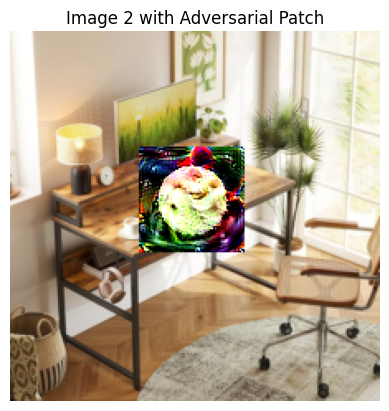

Predictions for Image 2:
Predicted: ice cream, Confidence: 0.9999
Predicted: cauliflower, Confidence: 0.0000
Predicted: dough, Confidence: 0.0000
Predicted: chocolate sauce, Confidence: 0.0000
Predicted: trifle, Confidence: 0.0000



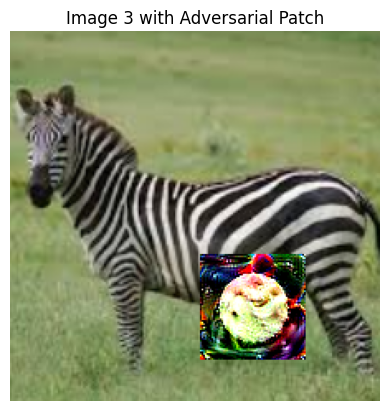

Predictions for Image 3:
Predicted: ice cream, Confidence: 0.9981
Predicted: trifle, Confidence: 0.0008
Predicted: chocolate sauce, Confidence: 0.0004
Predicted: candle, Confidence: 0.0003
Predicted: ice lolly, Confidence: 0.0001

Adversarial patch saved as 'adversarial_ice_cream_patch.png'


In [5]:
# Define patch size
patch_size = (64, 64)

# Load multiple test images
image_urls = [
    'https://images.squarespace-cdn.com/content/v1/5b5aa0922487fd1ce32c117a/1547765015801-FSR1DVSKCZU3PAYWIRQG/broccoli.jpg',
    'https://m.media-amazon.com/images/I/91vHzMdE4sL._AC_UF894,1000_QL80_.jpg',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR0ysMogdEKrU1o8VuUgiJ4LBrFiOs8oOqNZQ&s'
    ]
input_images = [load_image(url) for url in image_urls]

# Generate and apply the adversarial patch
adversarial_patch = generate_patch(model, input_images, target_class, iterations=600)

# Show the generated adversarial patch
show_image(adversarial_patch, title="Generated Adversarial Patch (Ice Cream Style)")

# Test the patch on multiple images
for idx, input_image in enumerate(input_images):
    # Apply the patch to a single random location
    patched_image = input_image.clone()
    y_offset = torch.randint(0, patched_image.size(2) - patch_size[0], (1,)).item()
    x_offset = torch.randint(0, patched_image.size(3) - patch_size[1], (1,)).item()
    patched_image[:, :, y_offset:y_offset+patch_size[0], x_offset:x_offset+patch_size[1]] = adversarial_patch

    # Display the patched image
    show_image(patched_image, title=f"Image {idx+1} with Adversarial Patch")

    # Get the model's prediction on the patched image
    patched_image = patched_image.to(device)
    with torch.no_grad():
        output = model(patched_image)
    _, indices = output.topk(5)

    # Show the top 5 predicted classes
    print(f"Predictions for Image {idx+1}:")
    for idx in indices[0]:
        print(f"Predicted: {labels[idx]}, Confidence: {F.softmax(output, dim=1)[0][idx].item():.4f}")
    print()

# Save the patch as an image file
adversarial_patch_np = adversarial_patch.squeeze().permute(1, 2, 0).cpu().detach().numpy()
adversarial_patch_np = np.clip(adversarial_patch_np * 255, 0, 255).astype(np.uint8)
adversarial_patch_img = Image.fromarray(adversarial_patch_np)
adversarial_patch_img.save("adversarial_ice_cream_patch.png")
